Setup

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
import CNN

# from config_plots import global_settings
# global_settings()
import warnings
warnings.filterwarnings("ignore")

Hyper parameters

In [2]:
# defining global variables
experimentName = "test_22987_suffix50_11_CNN2_differentConfig_fcwidth"
showListOfSpecies = False

from configParser import ConfigParser, getModelName
config_parser = ConfigParser(experimentName)

import os
experimentName = os.path.join(experimentName, "selected-multi-trial")
import TrialStatistics
ts = TrialStatistics.TrialStatistics(experimentName)
ts_genus = TrialStatistics.TrialStatistics(experimentName, "genus")

import dataLoader

Cuda support

In [3]:
# CUDA support 
if torch.cuda.is_available():
    torch.cuda.set_device(0) # 0
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("We are using cuda")

We are using cuda


Iterate

In [4]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from confusion_matrix_plotter import plot_confusion_matrix2, generate_classification_report
import numpy as np
import os
import progressbar

paramsIterator = config_parser.getHyperpSelectedIter()  
number_of_experiments = sum(1 for e in paramsIterator)
paramsIterator = config_parser.getHyperpSelectedIter()    
experiment_index = 0

datasetManager = dataLoader.datasetManager(experimentName, showListOfSpecies)
with progressbar.ProgressBar(max_value=number_of_experiments) as bar:
    for experiment_params in paramsIterator:
        bar.update(experiment_index)
        experiment_params["numOfTrials"] = experiment_params["numOfTrials"] or 1

        print("experiment ", experiment_index+1, "/", number_of_experiments, ": ", experiment_params)

        # load images
        datasetManager.updateParams(experiment_params)
        dataset = datasetManager.getDataset()
        speciesList = dataset.getSpeciesList()
        numberOfSpecies = len(speciesList)
        numberOfGenus = len(dataset.getGenusList())

        for i in range(experiment_params["numOfTrials"]):
            trialName = os.path.join(experimentName, getModelName(experiment_params, i))

            # Train/Load model
            architecture = {
                "species": numberOfSpecies,
                "genus" : numberOfGenus
            }
            model = CNN.create_model(architecture, experiment_params)
            train_loader, validation_loader, test_loader = datasetManager.getLoaders()
            if os.path.exists(CNN.getModelFile(trialName)):
                _, _, epochs, time_elapsed = CNN.loadModel(model, trialName)
                print("Model {0} loaded!".format(trialName))
            else:
                _, _, epochs, time_elapsed = CNN.trainModel(train_loader, validation_loader, experiment_params, model, trialName)

            # Update trial outcomes for statistics
            predlist, lbllist = CNN.getLoaderPredictions(test_loader, model, experiment_params)
            ts.addTrialPredictions(experiment_params, predlist, lbllist, numberOfSpecies)
            macro_f1 = f1_score(lbllist.cpu(), predlist.cpu(), average='macro')
            macro_f1_genus = np.nan
            if experiment_params["useHeirarchy"]:
                predlist, lbllist = CNN.getLoaderPredictions(test_loader, model, experiment_params, 'genus')
                ts_genus.addTrialPredictions(experiment_params, predlist, lbllist, numberOfGenus)
                macro_f1_genus = f1_score(lbllist.cpu(), predlist.cpu(), average='macro')

            ts.addTrial(experiment_params,
                    {'loss': CNN.getCrossEntropyFromLoader(test_loader, model, experiment_params),
                     'accuracy': CNN.getAccuracyFromLoader(test_loader, model, experiment_params),
                     'macro_f1_species': macro_f1,
                     'macro_f1_genus': macro_f1_genus,
                     'time': time_elapsed,
                     'epochs': epochs
                    }, i)
        
        experiment_index = experiment_index + 1

N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

experiment  1 / 4 :  {'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'validation_count': 0.16, 'imageDimension': 224, 'n_channels': 3, 'augmentation': False, 'batchSize': 550, 'n_epochs': 1000, 'learning_rate': 0.01, 'numOfTrials': 3, 'patience': 100, 'useHeirarchy': True, 'useRelu': True, 'downsample': True, 'downsampleOutput': 50, 'takeFromIntermediate': True, 'takeFromIntermediateOutput': 50, 'fc_layers': 1, 'useAdam': False, 'resnet': '18', 'normalize': False, 'softmax': False}
file /data/BGNN_data/INHS_cropped/50_11/test_22987_suffix50_11_CNN2_differentConfig_fcwidth/selected-multi-trial/tc0.640000_vc0.160000_d224_c3_augFalse_nFalse/dataset.pkl read
Loading saved dataloaders...
file /data/BGNN_data/INHS_cropped/50_11/test_22987_suffix50_11_CNN2_differentConfig_fcwidth/selected-multi-trial/tc0.640000_vc0.160000_d224_c3_augFalse_nFalse/trainingLoader.pkl read
file /data/BGNN_data/INHS_cropped/50_11/test_22987_suffix50_11_CNN2_differentConfig

 25% (1 of 4) |######                    | Elapsed Time: 0:01:40 ETA:   0:05:01

experiment  2 / 4 :  {'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'validation_count': 0.16, 'imageDimension': 224, 'n_channels': 3, 'augmentation': False, 'batchSize': 550, 'n_epochs': 1000, 'learning_rate': 0.01, 'numOfTrials': 3, 'patience': 100, 'useHeirarchy': True, 'useRelu': True, 'downsample': True, 'downsampleOutput': 100, 'takeFromIntermediate': True, 'takeFromIntermediateOutput': 100, 'fc_layers': 1, 'useAdam': False, 'resnet': '18', 'normalize': False, 'softmax': False}
Model test_22987_suffix50_11_CNN2_differentConfig_fcwidth/selected-multi-trial/tc0.640000_vc0.160000_d224_c3_augFalse_nFalse_bs550_e1000_p100_lr0.010000_hTrue_reluTrue_dsTrue_dso100_tfiTrue_tfio100_admFalse_res18_fc1_smaxFalse_id0 loaded!
Model test_22987_suffix50_11_CNN2_differentConfig_fcwidth/selected-multi-trial/tc0.640000_vc0.160000_d224_c3_augFalse_nFalse_bs550_e1000_p100_lr0.010000_hTrue_reluTrue_dsTrue_dso100_tfiTrue_tfio100_admFalse_res18_fc1_smaxFalse_id1

N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Training started...


100% (1000 of 1000) |####################| Elapsed Time: 3:21:37 Time:  3:21:37
N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

experiment  3 / 4 :  {'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'validation_count': 0.16, 'imageDimension': 224, 'n_channels': 3, 'augmentation': False, 'batchSize': 550, 'n_epochs': 1000, 'learning_rate': 0.01, 'numOfTrials': 3, 'patience': 100, 'useHeirarchy': True, 'useRelu': True, 'downsample': True, 'downsampleOutput': 200, 'takeFromIntermediate': True, 'takeFromIntermediateOutput': 200, 'fc_layers': 1, 'useAdam': False, 'resnet': '18', 'normalize': False, 'softmax': False}
Training started...


100% (1000 of 1000) |####################| Elapsed Time: 3:22:08 Time:  3:22:08
N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Training started...


100% (1000 of 1000) |####################| Elapsed Time: 3:21:29 Time:  3:21:29
N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Training started...


100% (1000 of 1000) |####################| Elapsed Time: 3:22:39 Time:  3:22:39
N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

experiment  4 / 4 :  {'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'validation_count': 0.16, 'imageDimension': 224, 'n_channels': 3, 'augmentation': False, 'batchSize': 550, 'n_epochs': 1000, 'learning_rate': 0.01, 'numOfTrials': 3, 'patience': 100, 'useHeirarchy': True, 'useRelu': True, 'downsample': True, 'downsampleOutput': 300, 'takeFromIntermediate': True, 'takeFromIntermediateOutput': 300, 'fc_layers': 1, 'useAdam': False, 'resnet': '18', 'normalize': False, 'softmax': False}
Training started...


100% (1000 of 1000) |####################| Elapsed Time: 3:22:22 Time:  3:22:22
N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Training started...


100% (1000 of 1000) |####################| Elapsed Time: 3:21:18 Time:  3:21:18
N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Training started...


100% (1000 of 1000) |####################| Elapsed Time: 3:21:18 Time:  3:21:18
100% (4 of 4) |#########################| Elapsed Time: 23:36:20 Time: 23:36:20


Analyze

In [5]:
ts.showStatistics()
ts.saveStatistics()

Aggregated statistics


In [6]:
ts.showStatistics(False)
ts.saveStatistics(False)

Raw statistics


,image_path,suffix,training_count,validation_count,imageDimension,n_channels,augmentation,batchSize,n_epochs,learning_rate,numOfTrials,patience,useHeirarchy,useRelu,downsample,downsampleOutput,takeFromIntermediate,takeFromIntermediateOutput,fc_layers,useAdam,resnet,normalize,softmax,loss,accuracy,macro_f1_species,macro_f1_genus,time,epochs,hash,trial
0,/data/BGNN_data/INHS_cropped,50_11,0.64,0.16,224,3,False,550,1000,0.01,3,100,True,True,True,50,True,50,1,False,18,False,False,0.667772,0.754545,0.754826,0.702635,13368.015031,1000.0,5755811598101128515,0
1,/data/BGNN_data/INHS_cropped,50_11,0.64,0.16,224,3,False,550,1000,0.01,3,100,True,True,True,50,True,50,1,False,18,False,False,0.655298,0.754545,0.756343,0.848470,13480.612672,1000.0,5755811598101128515,1
2,/data/BGNN_data/INHS_cropped,50_11,0.64,0.16,224,3,False,550,1000,0.01,3,100,True,True,True,50,True,50,1,False,18,False,False,0.635074,0.736364,0.734007,0.828020,13429.127294,1000.0,5755811598101128515,2
3,/data/BGNN_data/INHS_cropped,50_11,0.64,0.16,224,3,False,550,1000,0.01,3,100,True,True,True,100,True,100,1,False,18,False,False,0.666605,0.727273,0.728018,0.712158,12491.820528,1000.0,4489596469621661411,0
4,/data/BGNN_data/INHS_cropped,50_11,0.64,0.16,224,3,False,550,1000,0.01,3,100,True,True,True,100,True,100,1,False,18,False,False,0.656275,0.763636,0.763406,0.694950,12525.418909,1000.0,4489596469621661411,1
5,/data/BGNN_data/INHS_cropped,50_11,0.64,0.16,224,3,False,550,1000,0.01,3,100,True,True,True,100,True,100,1,False,18,False,False,0.646919,0.727273,0.726501,0.693127,12097.465716,1000.0,4489596469621661411,2
6,/data/BGNN_data/INHS_cropped,50_11,0.64,0.16,224,3,False,550,1000,0.01,3,100,True,True,True,200,True,200,1,False,18,False,False,0.624607,0.772727,0.772997,0.539643,12128.079875,1000.0,-860712046365630528,0
7,/data/BGNN_data/INHS_cropped,50_11,0.64,0.16,224,3,False,550,1000,0.01,3,100,True,True,True,200,True,200,1,False,18,False,False,0.668761,0.718182,0.712930,0.709260,12089.315122,1000.0,-860712046365630528,1
8,/data/BGNN_data/INHS_cropped,50_11,0.64,0.16,224,3,False,550,1000,0.01,3,100,True,True,True,200,True,200,1,False,18,False,False,0.639810,0.763636,0.764512,0.842284,12158.991771,1000.0,-860712046365630528,2
9,/data/BGNN_data/INHS_cropped,50_11,0.64,0.16,224,3,False,550,1000,0.01,3,100,True,True,True,300,True,300,1,False,18,False,False,0.649144,0.690909,0.686212,0.524581,12142.470060,1000.0,-4918937833304185214,0


experiment:  {'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'validation_count': 0.16, 'imageDimension': 224, 'n_channels': 3, 'augmentation': False, 'batchSize': 550, 'n_epochs': 1000, 'learning_rate': 0.01, 'numOfTrials': 3, 'patience': 100, 'useHeirarchy': True, 'useRelu': True, 'downsample': True, 'downsampleOutput': 50, 'takeFromIntermediate': True, 'takeFromIntermediateOutput': 50, 'fc_layers': 1, 'useAdam': False, 'resnet': '18', 'normalize': False, 'softmax': False}


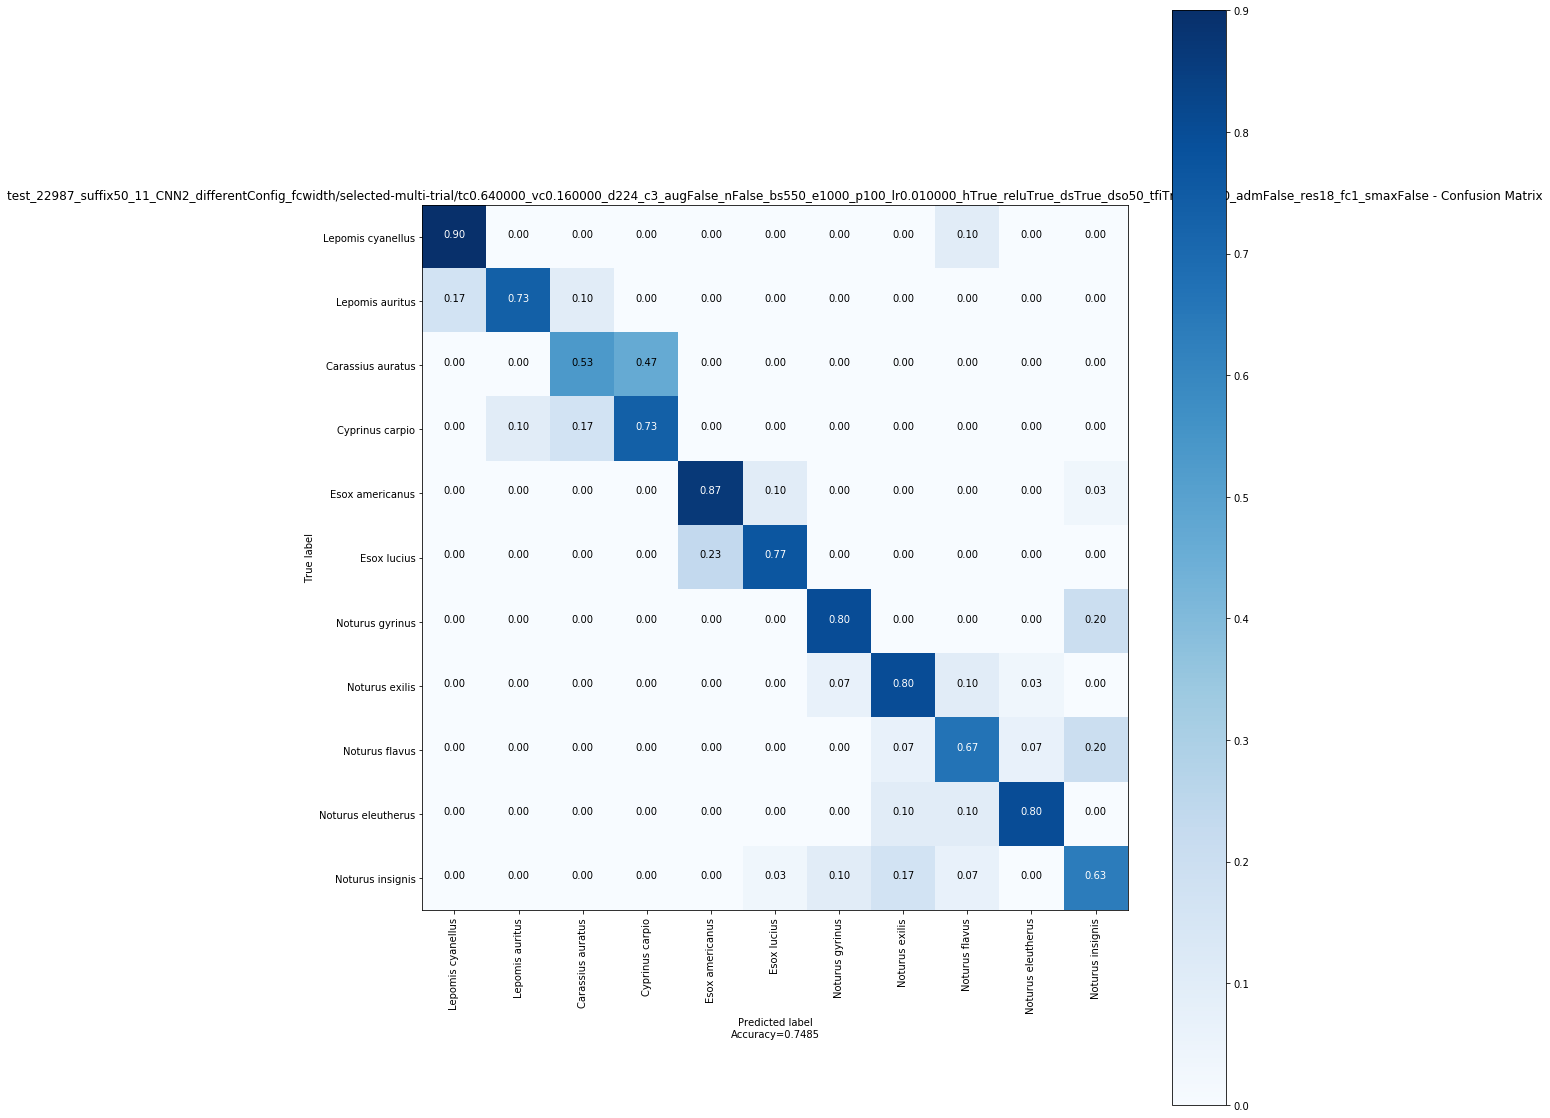

,species,genus,F1,F1_within_genus,F1_out_of_genus
0,0 Lepomis cyanellus,0 Lepomis,0.870968,0.915254,0.947368
1,1 Lepomis auritus,0 Lepomis,0.800000,0.897959,0.880000
2,2 Carassius auratus,1 Carassius,0.592593,1.000000,0.592593
3,3 Cyprinus carpio,2 Cyprinus,0.666667,1.000000,0.666667
4,4 Esox americanus,3 Esox,0.825397,0.838710,0.981132
5,5 Esox lucius,3 Esox,0.807018,0.821429,0.978723
6,6 Noturus gyrinus,4 Noturus,0.813559,0.813559,1.000000
7,7 Noturus exilis,4 Noturus,0.750000,0.750000,1.000000
8,8 Noturus flavus,4 Noturus,0.655738,0.689655,0.930233
9,9 Noturus eleutherus,4 Noturus,0.842105,0.842105,1.000000


experiment:  {'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'validation_count': 0.16, 'imageDimension': 224, 'n_channels': 3, 'augmentation': False, 'batchSize': 550, 'n_epochs': 1000, 'learning_rate': 0.01, 'numOfTrials': 3, 'patience': 100, 'useHeirarchy': True, 'useRelu': True, 'downsample': True, 'downsampleOutput': 100, 'takeFromIntermediate': True, 'takeFromIntermediateOutput': 100, 'fc_layers': 1, 'useAdam': False, 'resnet': '18', 'normalize': False, 'softmax': False}


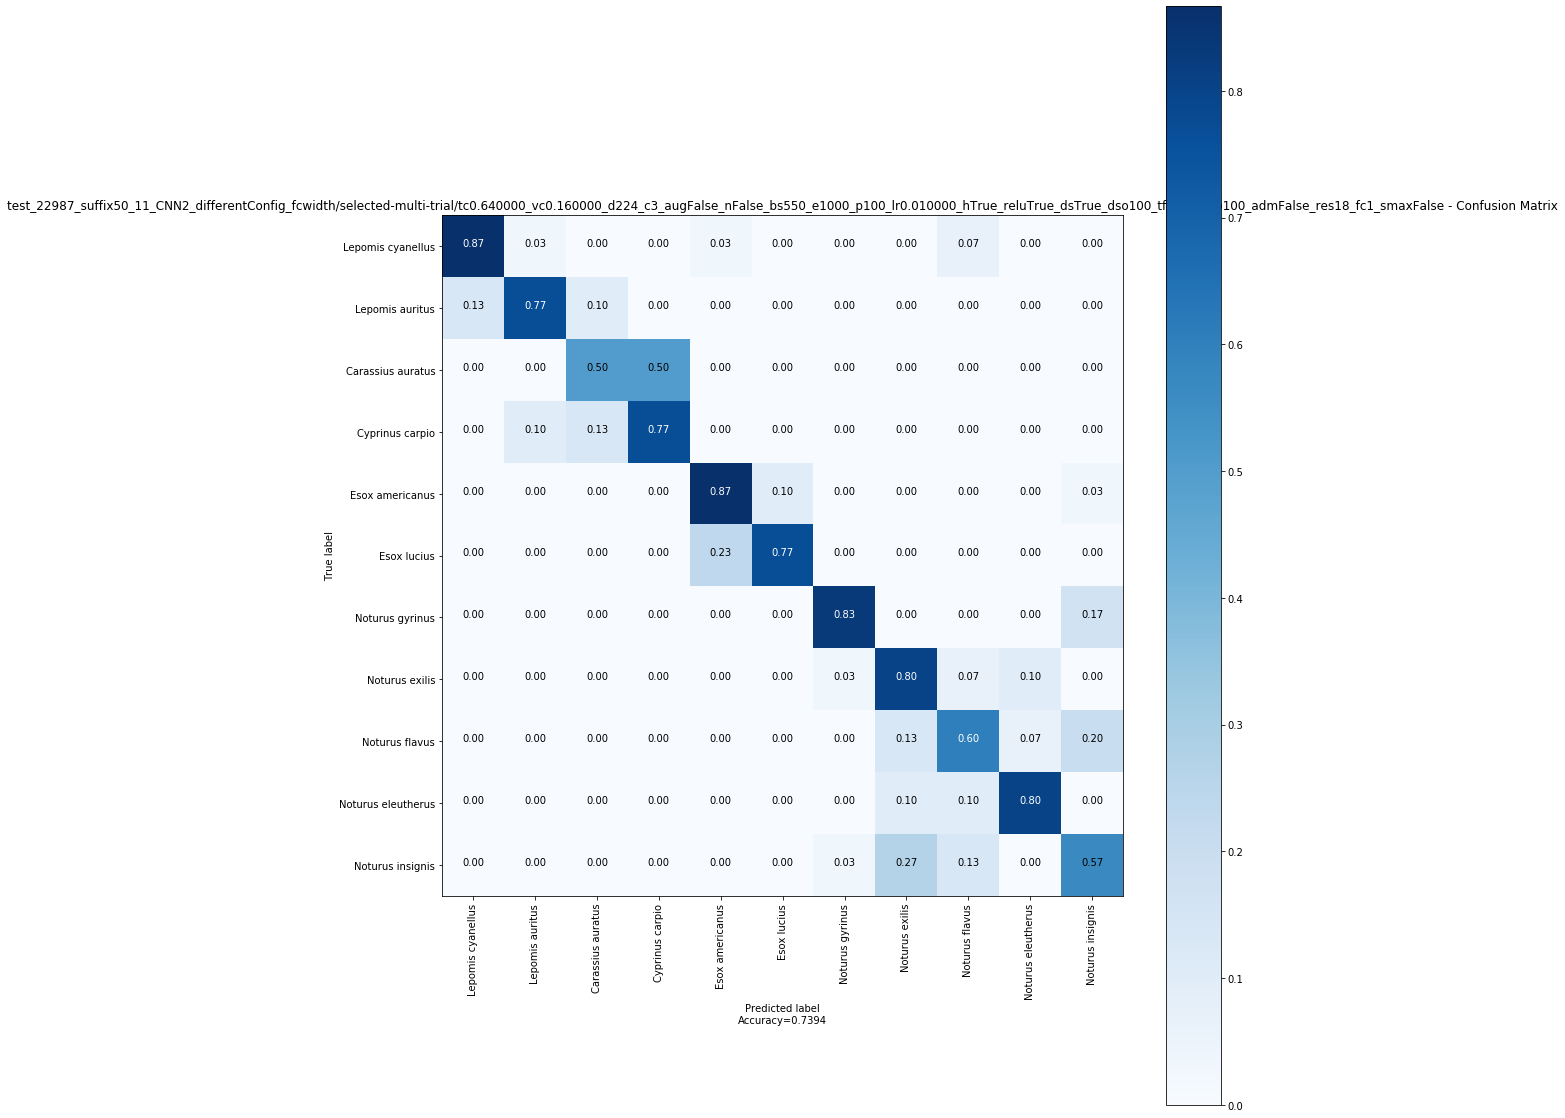

,species,genus,F1,F1_within_genus,F1_out_of_genus
0,0 Lepomis cyanellus,0 Lepomis,0.866667,0.912281,0.945455
1,1 Lepomis auritus,0 Lepomis,0.807018,0.901961,0.884615
2,2 Carassius auratus,1 Carassius,0.576923,1.000000,0.576923
3,3 Cyprinus carpio,2 Cyprinus,0.676471,1.000000,0.676471
4,4 Esox americanus,3 Esox,0.812500,0.838710,0.962963
5,5 Esox lucius,3 Esox,0.821429,0.821429,1.000000
6,6 Noturus gyrinus,4 Noturus,0.877193,0.877193,1.000000
7,7 Noturus exilis,4 Noturus,0.695652,0.695652,1.000000
8,8 Noturus flavus,4 Noturus,0.610169,0.631579,0.947368
9,9 Noturus eleutherus,4 Noturus,0.813559,0.813559,1.000000


experiment:  {'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'validation_count': 0.16, 'imageDimension': 224, 'n_channels': 3, 'augmentation': False, 'batchSize': 550, 'n_epochs': 1000, 'learning_rate': 0.01, 'numOfTrials': 3, 'patience': 100, 'useHeirarchy': True, 'useRelu': True, 'downsample': True, 'downsampleOutput': 200, 'takeFromIntermediate': True, 'takeFromIntermediateOutput': 200, 'fc_layers': 1, 'useAdam': False, 'resnet': '18', 'normalize': False, 'softmax': False}


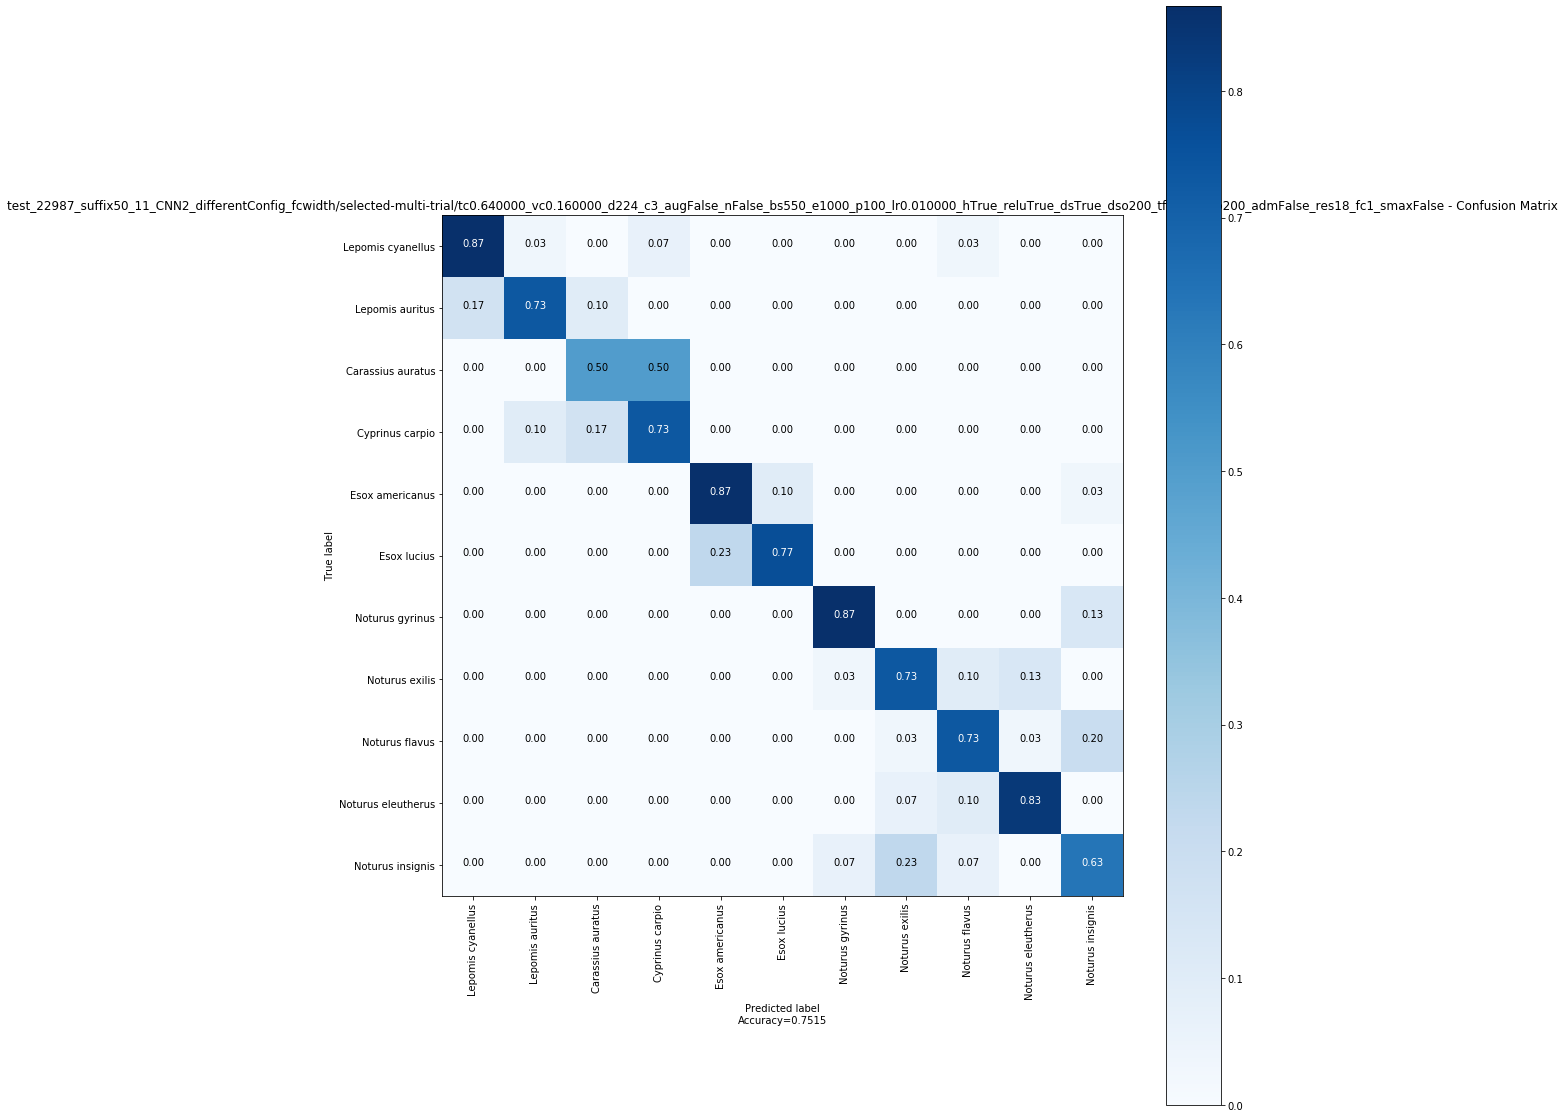

,species,genus,F1,F1_within_genus,F1_out_of_genus
0,0 Lepomis cyanellus,0 Lepomis,0.852459,0.896552,0.945455
1,1 Lepomis auritus,0 Lepomis,0.785714,0.880000,0.880000
2,2 Carassius auratus,1 Carassius,0.566038,1.000000,0.566038
3,3 Cyprinus carpio,2 Cyprinus,0.637681,1.000000,0.637681
4,4 Esox americanus,3 Esox,0.825397,0.838710,0.981132
5,5 Esox lucius,3 Esox,0.821429,0.821429,1.000000
6,6 Noturus gyrinus,4 Noturus,0.881356,0.881356,1.000000
7,7 Noturus exilis,4 Noturus,0.709677,0.709677,1.000000
8,8 Noturus flavus,4 Noturus,0.721311,0.733333,0.977778
9,9 Noturus eleutherus,4 Noturus,0.833333,0.833333,1.000000


experiment:  {'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'validation_count': 0.16, 'imageDimension': 224, 'n_channels': 3, 'augmentation': False, 'batchSize': 550, 'n_epochs': 1000, 'learning_rate': 0.01, 'numOfTrials': 3, 'patience': 100, 'useHeirarchy': True, 'useRelu': True, 'downsample': True, 'downsampleOutput': 300, 'takeFromIntermediate': True, 'takeFromIntermediateOutput': 300, 'fc_layers': 1, 'useAdam': False, 'resnet': '18', 'normalize': False, 'softmax': False}


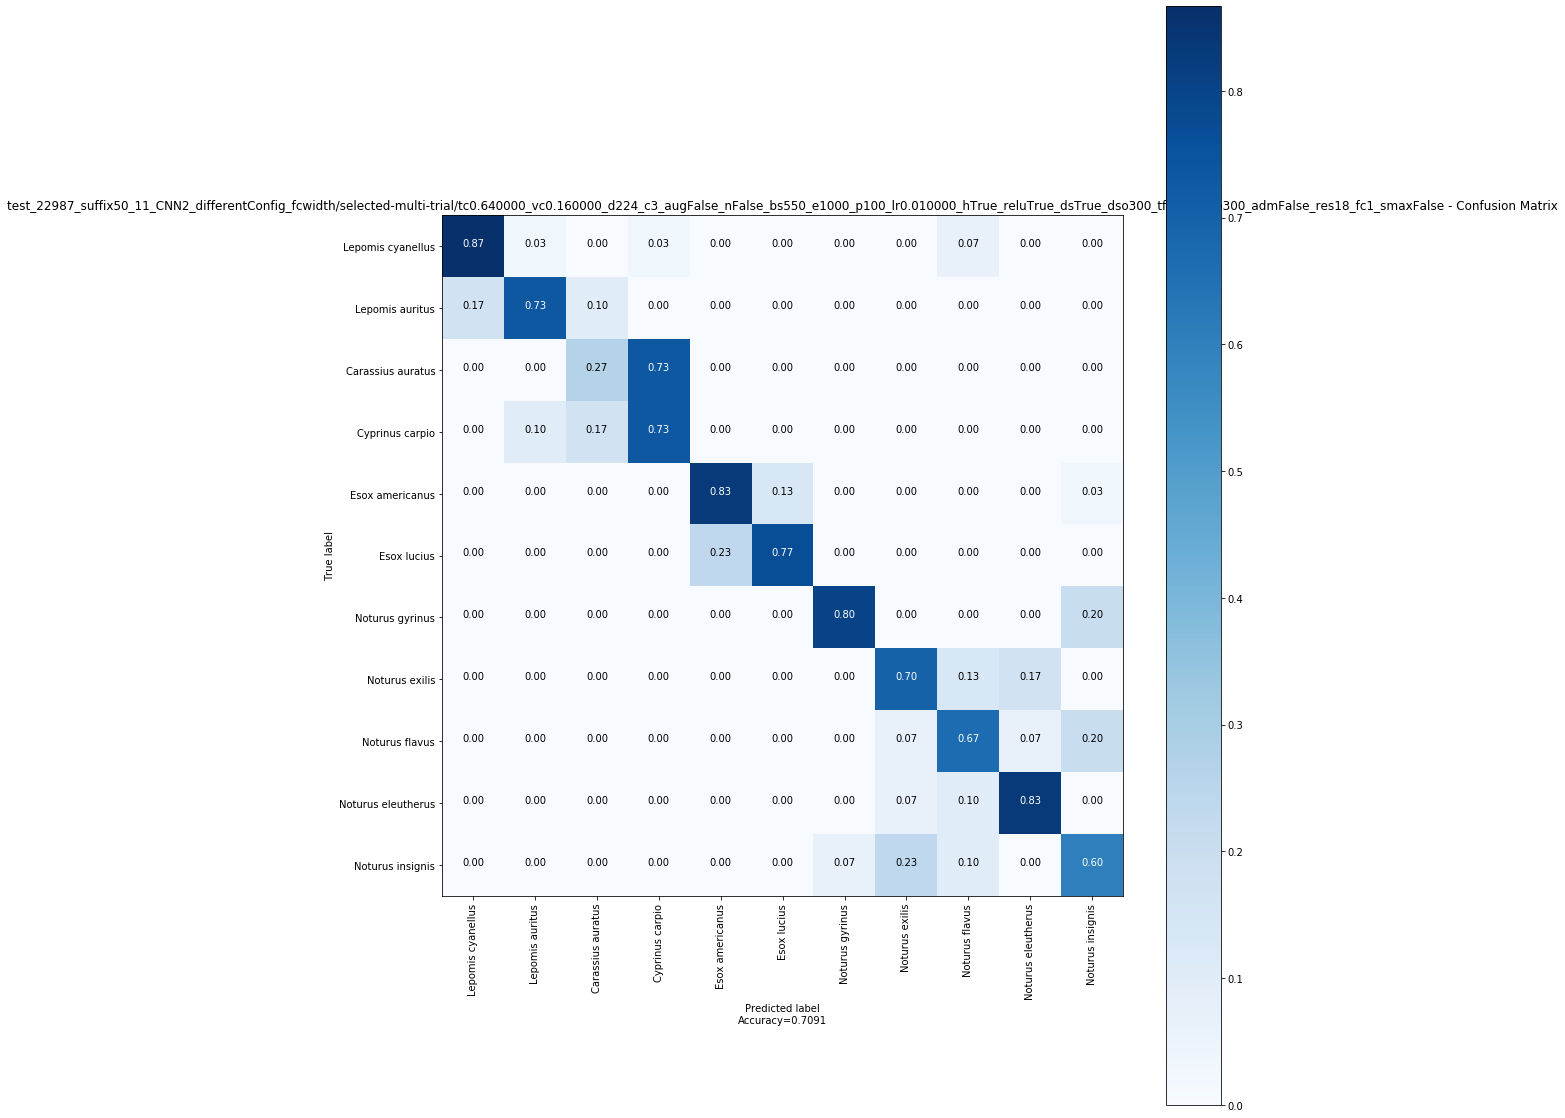

,species,genus,F1,F1_within_genus,F1_out_of_genus
0,0 Lepomis cyanellus,0 Lepomis,0.852459,0.896552,0.945455
1,1 Lepomis auritus,0 Lepomis,0.785714,0.880000,0.880000
2,2 Carassius auratus,1 Carassius,0.347826,1.000000,0.347826
3,3 Cyprinus carpio,2 Cyprinus,0.586667,1.000000,0.586667
4,4 Esox americanus,3 Esox,0.806452,0.819672,0.980392
5,5 Esox lucius,3 Esox,0.807018,0.807018,1.000000
6,6 Noturus gyrinus,4 Noturus,0.857143,0.857143,1.000000
7,7 Noturus exilis,4 Noturus,0.677419,0.677419,1.000000
8,8 Noturus flavus,4 Noturus,0.645161,0.666667,0.952381
9,9 Noturus eleutherus,4 Noturus,0.806452,0.806452,1.000000


In [7]:
paramsIterator = config_parser.getHyperpSelectedIter() 
for experiment_params in paramsIterator:
    experiment_params["numOfTrials"] = experiment_params["numOfTrials"] or 1
    
    print("experiment: ", experiment_params)
    
    datasetManager.updateParams(experiment_params)
    dataset = datasetManager.getDataset()
    speciesList = dataset.getSpeciesList()
    ts.printTrialConfusionMatrix(experiment_params, speciesList, True)
    ts.printF1table(experiment_params, dataset)

experiment:  {'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'validation_count': 0.16, 'imageDimension': 224, 'n_channels': 3, 'augmentation': False, 'batchSize': 550, 'n_epochs': 1000, 'learning_rate': 0.01, 'numOfTrials': 3, 'patience': 100, 'useHeirarchy': True, 'useRelu': True, 'downsample': True, 'downsampleOutput': 50, 'takeFromIntermediate': True, 'takeFromIntermediateOutput': 50, 'fc_layers': 1, 'useAdam': False, 'resnet': '18', 'normalize': False, 'softmax': False}


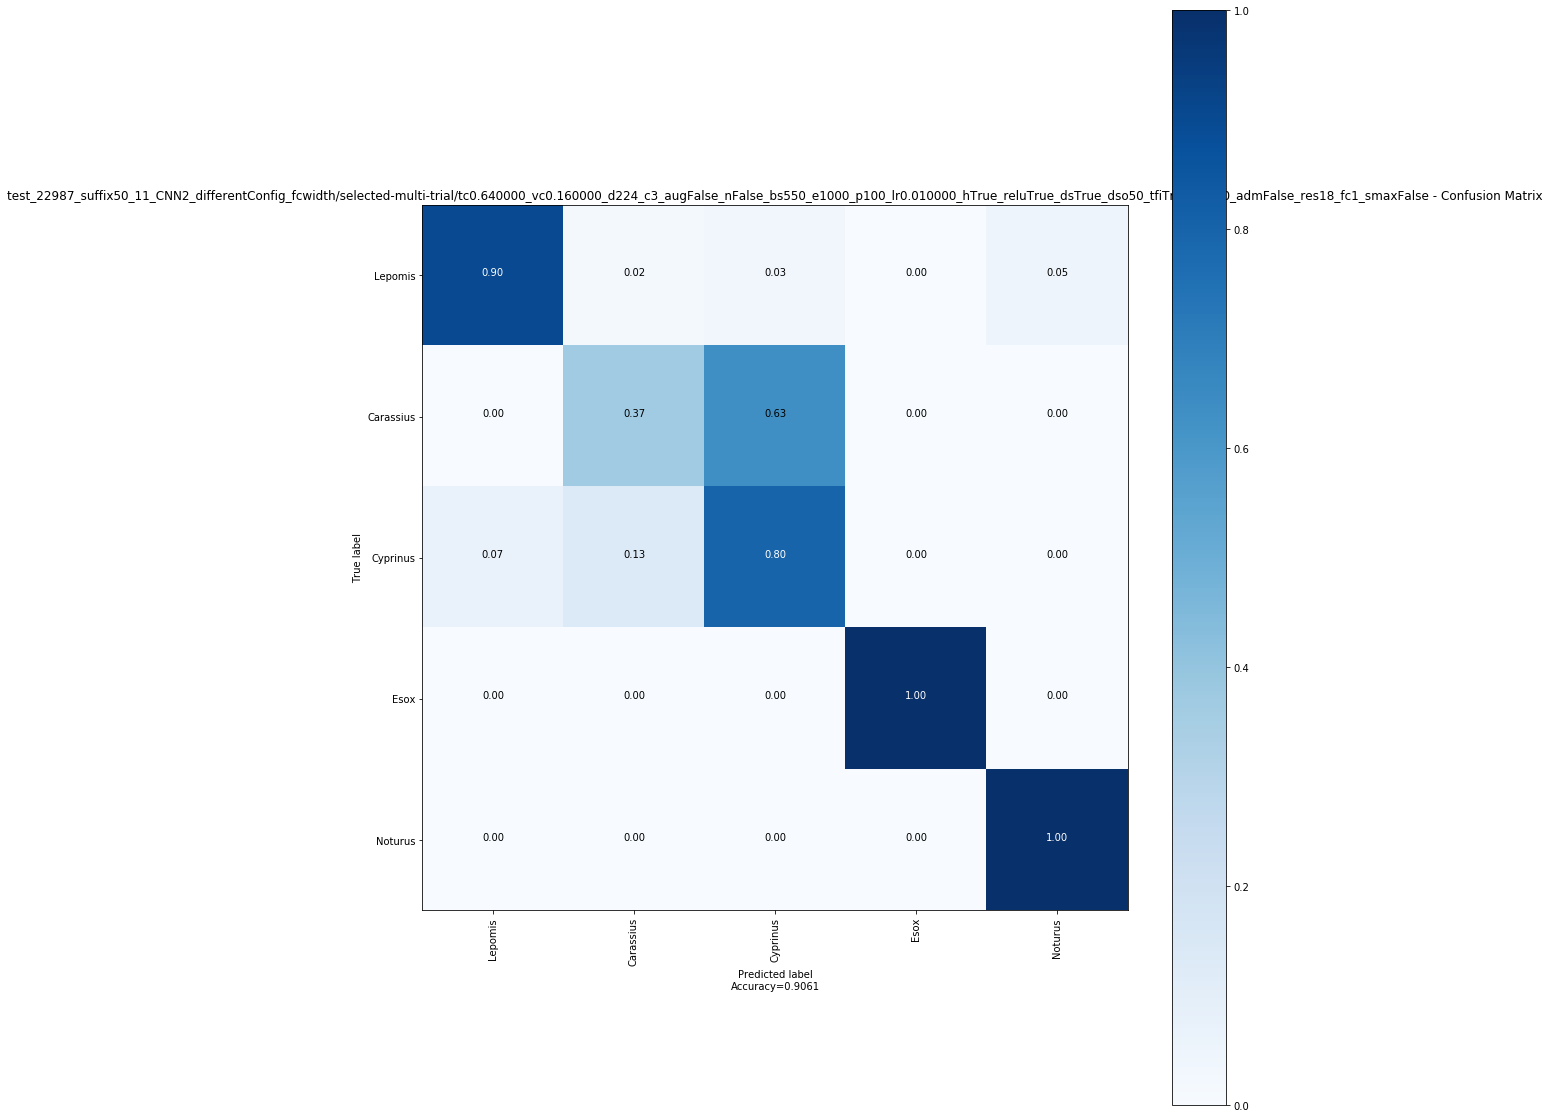

,genus,F1
0,0 Lepomis,0.931034
1,1 Carassius,0.478261
2,2 Cyprinus,0.640000
3,3 Esox,1.000000
4,4 Noturus,0.990099


experiment:  {'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'validation_count': 0.16, 'imageDimension': 224, 'n_channels': 3, 'augmentation': False, 'batchSize': 550, 'n_epochs': 1000, 'learning_rate': 0.01, 'numOfTrials': 3, 'patience': 100, 'useHeirarchy': True, 'useRelu': True, 'downsample': True, 'downsampleOutput': 100, 'takeFromIntermediate': True, 'takeFromIntermediateOutput': 100, 'fc_layers': 1, 'useAdam': False, 'resnet': '18', 'normalize': False, 'softmax': False}


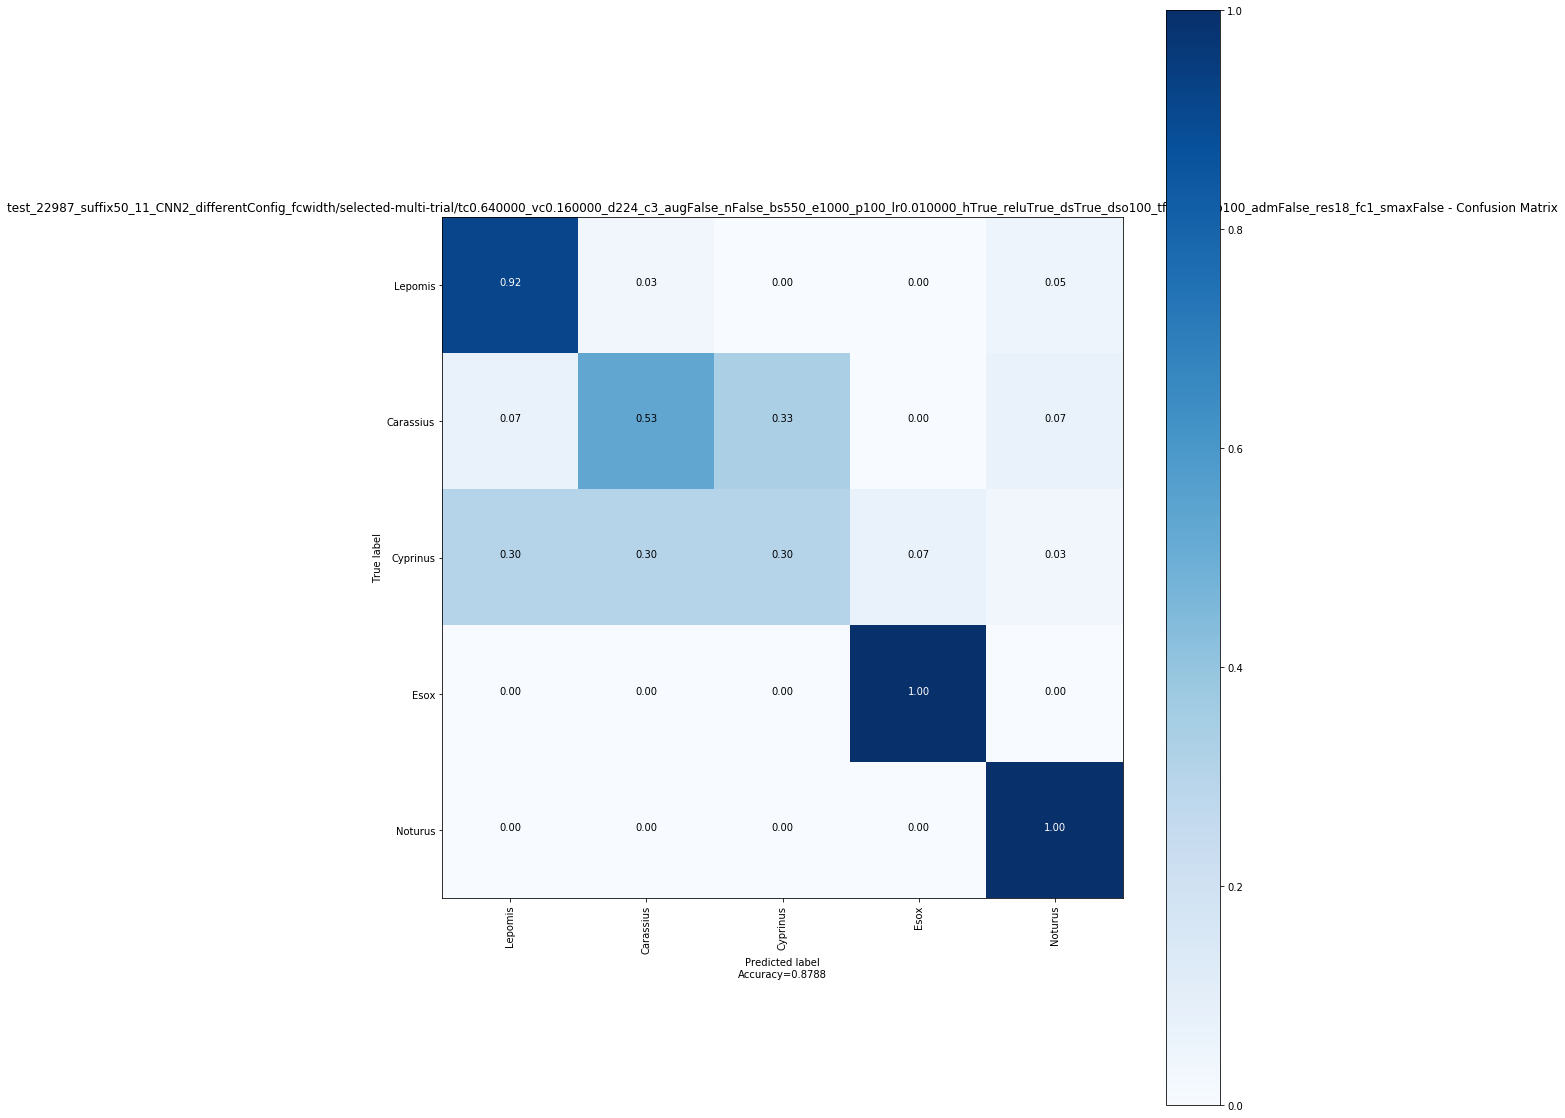

,genus,F1
0,0 Lepomis,0.873016
1,1 Carassius,0.561404
2,2 Cyprinus,0.367347
3,3 Esox,0.983607
4,4 Noturus,0.980392


experiment:  {'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'validation_count': 0.16, 'imageDimension': 224, 'n_channels': 3, 'augmentation': False, 'batchSize': 550, 'n_epochs': 1000, 'learning_rate': 0.01, 'numOfTrials': 3, 'patience': 100, 'useHeirarchy': True, 'useRelu': True, 'downsample': True, 'downsampleOutput': 200, 'takeFromIntermediate': True, 'takeFromIntermediateOutput': 200, 'fc_layers': 1, 'useAdam': False, 'resnet': '18', 'normalize': False, 'softmax': False}


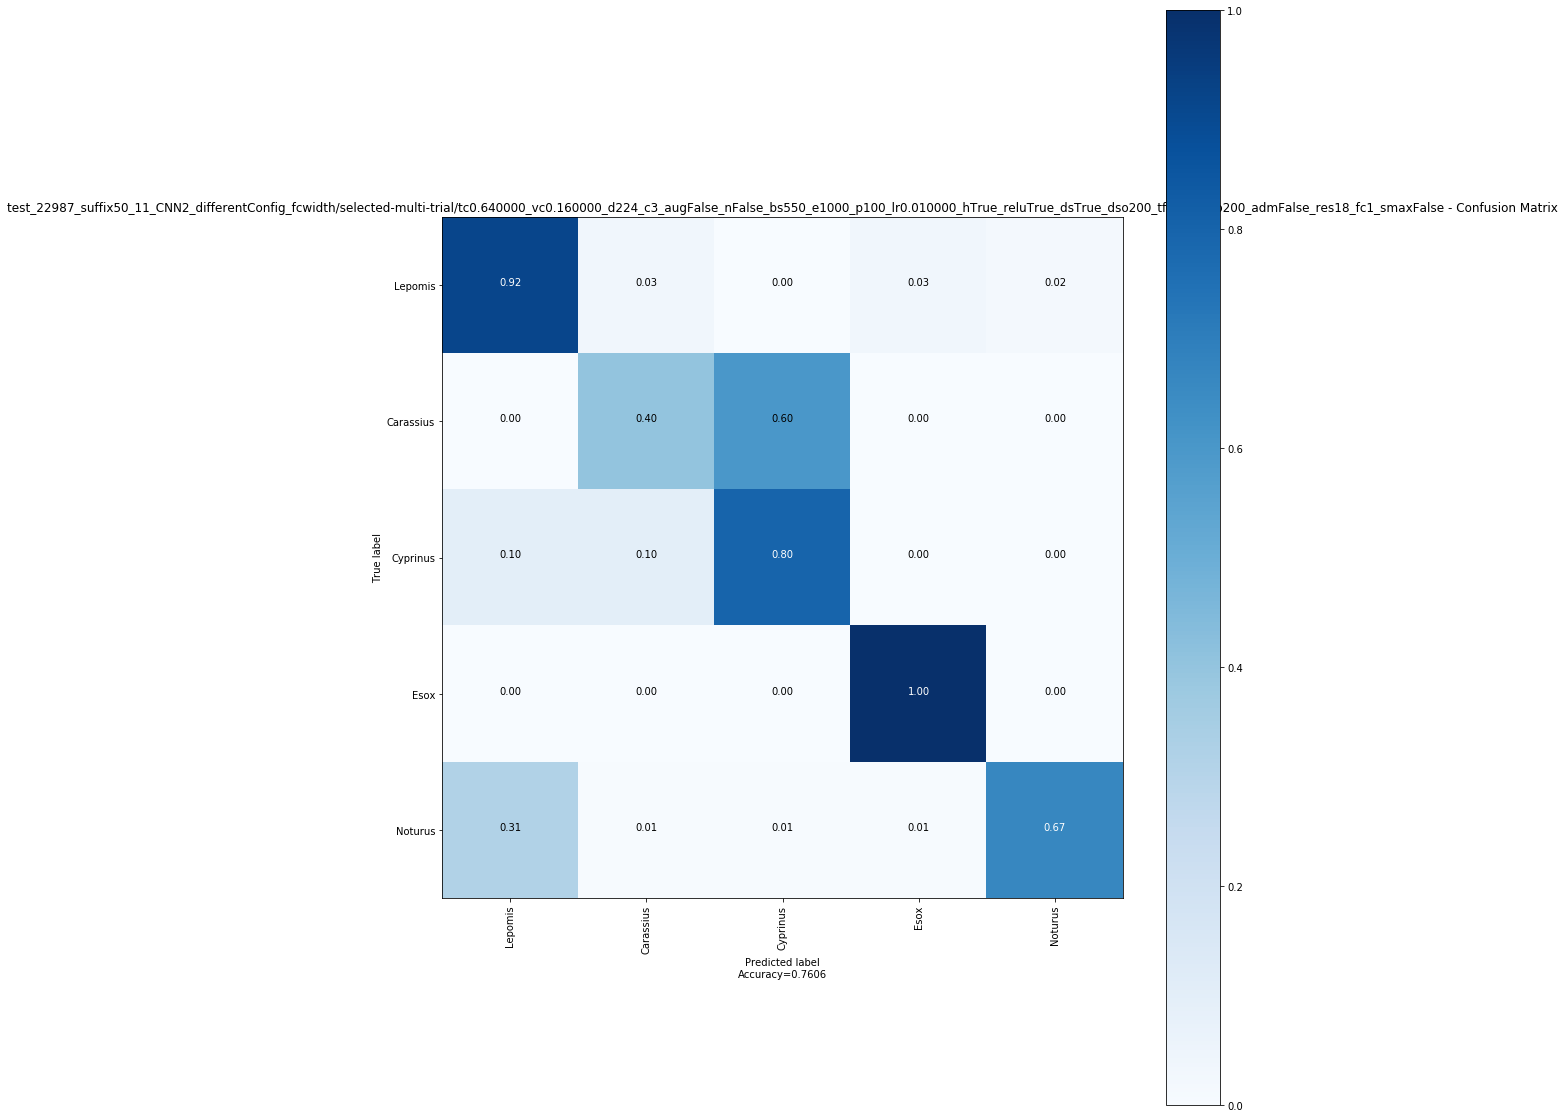

,genus,F1
0,0 Lepomis,0.666667
1,1 Carassius,0.500000
2,2 Cyprinus,0.657534
3,3 Esox,0.975610
4,4 Noturus,0.796813


experiment:  {'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'validation_count': 0.16, 'imageDimension': 224, 'n_channels': 3, 'augmentation': False, 'batchSize': 550, 'n_epochs': 1000, 'learning_rate': 0.01, 'numOfTrials': 3, 'patience': 100, 'useHeirarchy': True, 'useRelu': True, 'downsample': True, 'downsampleOutput': 300, 'takeFromIntermediate': True, 'takeFromIntermediateOutput': 300, 'fc_layers': 1, 'useAdam': False, 'resnet': '18', 'normalize': False, 'softmax': False}


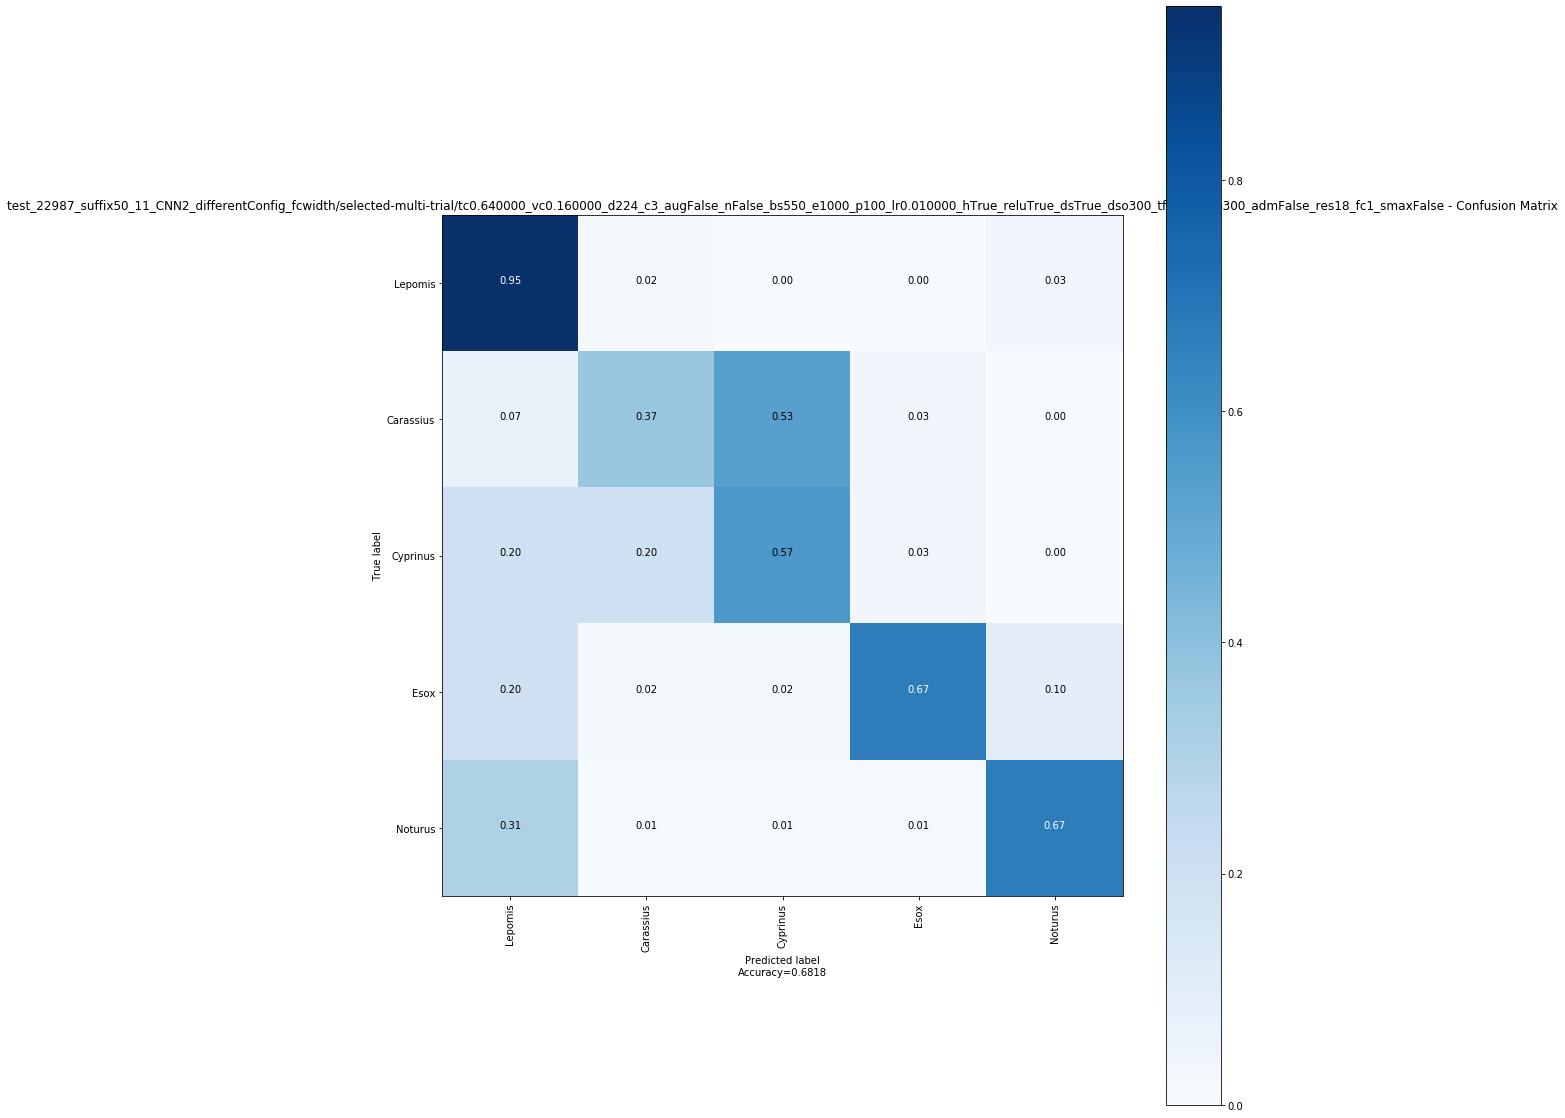

,genus,F1
0,0 Lepomis,0.622951
1,1 Carassius,0.440000
2,2 Cyprinus,0.523077
3,3 Esox,0.769231
4,4 Noturus,0.775194


In [8]:
paramsIterator = config_parser.getHyperpSelectedIter() 
for experiment_params in paramsIterator:
    experiment_params["numOfTrials"] = experiment_params["numOfTrials"] or 1
    if experiment_params["useHeirarchy"]:
        print("experiment: ", experiment_params)

        datasetManager.updateParams(experiment_params)
        dataset = datasetManager.getDataset()
    
        genusList = dataset.getGenusList()
        ts_genus.printTrialConfusionMatrix(experiment_params, genusList, True)
        ts_genus.printF1table(experiment_params, dataset)

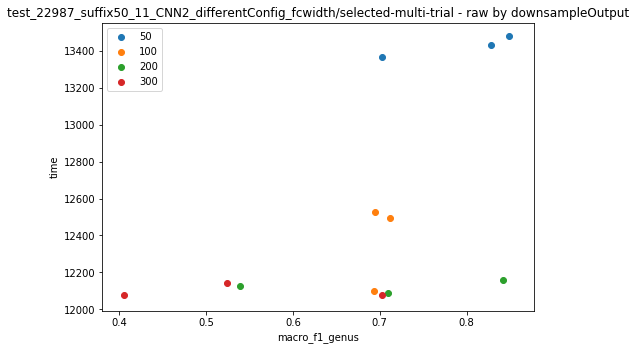

In [15]:
ts.trialScatter('macro_f1_genus', 'time', False, 'downsampleOutput')

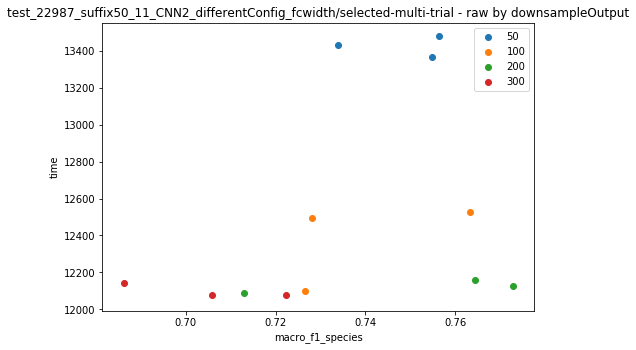

In [13]:
ts.trialScatter('macro_f1_species', 'time', False, 'downsampleOutput')